In [23]:
from functools import partial
from jax import numpy as jnp, random, vmap
import matplotlib.pyplot as plt

import models
from filtering import filter_sweep

rk = random.PRNGKey(0)

n_players = 10
n_matches = 200

init_mean = 0.
init_sd = 1.
tau = 1.
s = 2.
epsilon = 1.

mt_key, mi_key, init_skill_key, sim_key, filter_key, init_particle_key = random.split(rk, 6)

match_times = random.uniform(mt_key, shape=(n_matches,)).sort()
mi_keys = random.split(mi_key, n_matches)
match_indices_seq = vmap(lambda rk: random.choice(rk, a=jnp.arange(n_players, ), shape=(2,), replace=False))(mi_keys)

init_player_times = jnp.zeros(n_players)
init_player_skills = init_mean + init_sd * random.normal(init_skill_key, shape=(n_players,))


# Simulate data from trueskill model
sim_skills_p1, sim_skills_p2, sim_results = models.trueskill.simulate(init_player_times,
                                                                      init_player_skills,
                                                                      match_times,
                                                                      match_indices_seq,
                                                                      tau,
                                                                      [s, epsilon],
                                                                      sim_key)
# Filter (with arbitrary parameters)
filter_sweep_data = partial(filter_sweep,
                            init_player_times=init_player_times,
                            match_times=match_times,
                            match_player_indices_seq=match_indices_seq,
                            match_results=sim_results,
                            random_key=filter_key)

elo_filter_out = filter_sweep_data(models.elo.filter,
                                   init_player_skills=init_player_skills,
                                   static_propagate_params=None, static_update_params=[1., 1.])

init_player_skills_and_var = jnp.vstack([init_player_skills, jnp.ones(n_players)]).T
glicko_filter_out = filter_sweep_data(models.glicko.filter,
                                      init_player_skills=init_player_skills_and_var,
                                      static_propagate_params=[1., 350 ** 2], static_update_params=None)

trueskill_filter_out = filter_sweep_data(models.trueskill.filter,
                                         init_player_skills=init_player_skills_and_var,
                                         static_propagate_params=tau, static_update_params=[s, epsilon])

n_particles = 100
init_player_skills_particles = init_player_skills.reshape(n_players, 1) \
                               + init_sd * random.normal(init_particle_key, shape=(n_players, n_particles))
lsmc_filter_out = filter_sweep_data(models.lsmc.filter,
                                    init_player_skills=init_player_skills_particles,
                                    static_propagate_params=tau, static_update_params=[s, epsilon])

In [14]:
initial_distribution_skills = jnp.zeros((10))
initial_distribution_skills = initial_distribution_skills.at[0].set(0.8)
initial_distribution_skills = initial_distribution_skills.at[1].set(0.2)

_, initial_distribution_skills_player = models.discreteskill.initiator(n_players, initial_distribution_skills, rk)

discrete_filter_out  = filter_sweep_data(models.discreteskill.filter,
                                         init_player_skills=initial_distribution_skills_player,
                                         static_propagate_params=tau, static_update_params=[s, epsilon])

In [25]:
# Plot results
bin_width = 0.2
inds = jnp.arange(20)#n_matches)
alph = 0.5


def plot_predictions(ax, predictions, barpos):
    ax.bar(inds + barpos * bin_width, predictions[:, 2], bottom=1 - predictions[:, 2], width=bin_width * 0.8,
           color='purple', alpha=alph)  # p2 wins
    ax.bar(inds + barpos * bin_width, predictions[:, 0], bottom=predictions[:, 1], width=bin_width * 0.8, color='blue',
           alpha=alph)  # draw
    ax.bar(inds + barpos * bin_width, predictions[:, 1], bin_width * 0.8, color='green', alpha=alph)  # p1 wins


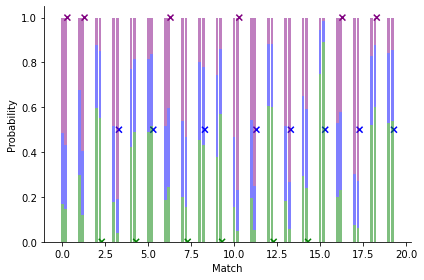

In [26]:
fig, ax = plt.subplots()
plot_predictions(ax, discrete_filter_out[-1][-20:,:], 0)
# plot_predictions(ax, glicko_filter_out[-1], 1)
# plot_predictions(ax, trueskill_filter_out[-1], 2)
plot_predictions(ax, lsmc_filter_out[-1][-20:,:], 1)
# plot_predictions(ax, discrete_filter_out[-1], 4)

res_cols = [['blue', 'green', 'purple'][r] for r in sim_results[-20:]]
res_to_probpos = {0: 0.5, 1: 0, 2: 1}
res_probs = [res_to_probpos[int(r)] for r in sim_results[-20:]]
ax.scatter(inds + bin_width * 1.5, res_probs, c=res_cols, marker='x')
ax.set_xlabel('Match')
ax.set_ylabel('Probability')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()

In [16]:
discrete_filter_out[-1].shape

(200, 3)